## Workflow_by Flora Chen

#### 1. create adata by reading the file
#### 2. QC matrix (
        check n_genes_by_counts, total_counts, and pct_genes_mt
#### 3. 1st filtering 
        filter out cells with <200 genes expressed, and genes detected < 5 cells 
#### 4. 2nd filtering
        filter out high total counts >6500, cells of mt genes >10% and those with hb >10%
#### 5. Doublet detection and removal (just 1)
#### 6. Normalisation
        natural log
#### 7. Identify highly variable genes
        min_mean =0.0125, max_mean=5, min_disp =0.5

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

# Core scverse libraries
import scanpy as sc
import anndata as ad

In [2]:
#set working directory

print("Previous Working Directory:", os.getcwd())

# Change the current working directory (replace with an actual directory on your system)
new_directory = "/Users/florachen/bioinformatics/final_project/mm_blood_10x/"
os.chdir(new_directory)

print("Current Working Directory:",new_directory)


Previous Working Directory: /Users/florachen/bioinformatics/final_project
Current Working Directory: /Users/florachen/bioinformatics/final_project/mm_blood_10x/


## Set sample id

In [3]:
sample_id="blood_12w_KO_02"

In [4]:
adata = sc.read_10x_mtx(
    "/Users/florachen/bioinformatics/final_project/mm_blood_10x/blood_12w_KO_02/mtx",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

adata.var_names_make_unique()

adata #n_obs x n_vars =6223 x 32285

AnnData object with n_obs × n_vars = 6224 × 32285
    var: 'gene_ids', 'feature_types'

In [5]:
#have a look at the top20 expressed genes
#sc.pl.highest_expr_genes(adata, n_top=20)

# QC matrix



In [6]:
#annotate mt,ribo, and hb genes

# mitochondrial genes, "MT-" for human, "mt-" for mouse !!!! both lowercase!!
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("Rps", "Rpl")) #mice? Rps and Rpl
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("Hbb")

#check the number of each genes
print("mt genes:",adata.var["mt"].sum()) #13
print("ribo genes:",adata.var["ribo"].sum()) #101
print("hb genes:", adata.var["hb"].sum()) #5


mt genes: 13
ribo genes: 101
hb genes: 5


In [7]:
#qc matrix for mt, ribo, and hb
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt", "ribo", "hb"], inplace=True, log1p=False)

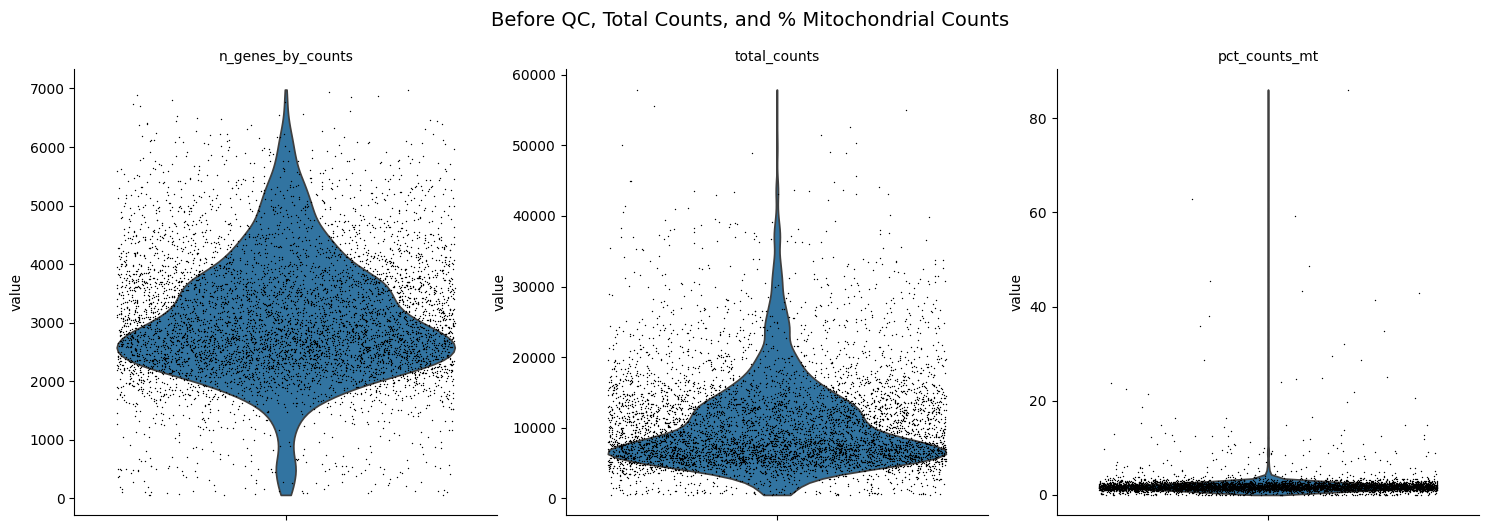

In [8]:
#violin plots 
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    show=False
)
# Add a summary title
plt.suptitle("Before QC, Total Counts, and % Mitochondrial Counts", fontsize=14, y=1.05)

# Display the updated figure
plt.show()


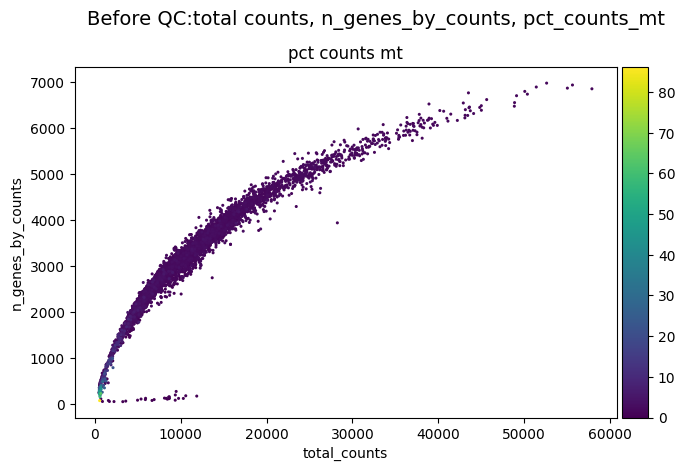

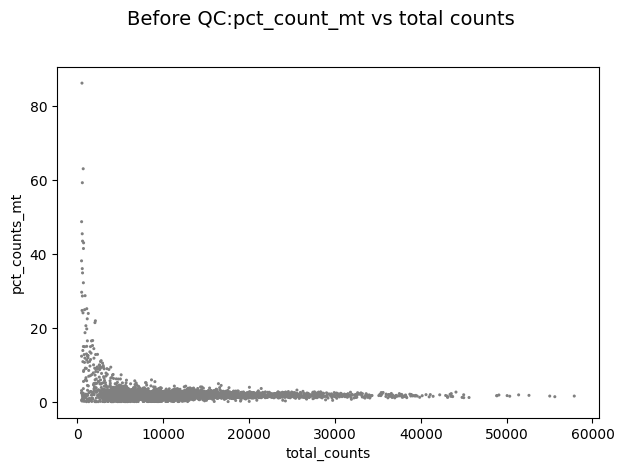

In [9]:
#scatter plot of total counts, n_genes_by_counts, pct_counts_mt
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", show = False)
plt.suptitle ("Before QC:total counts, n_genes_by_counts, pct_counts_mt ", fontsize=14, y=1)
plt.show()

#scatter plot of pct_count_mt vs total counts
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show =False)
plt.suptitle ("Before QC:pct_count_mt vs total counts", fontsize=14, y=1)
plt.show()

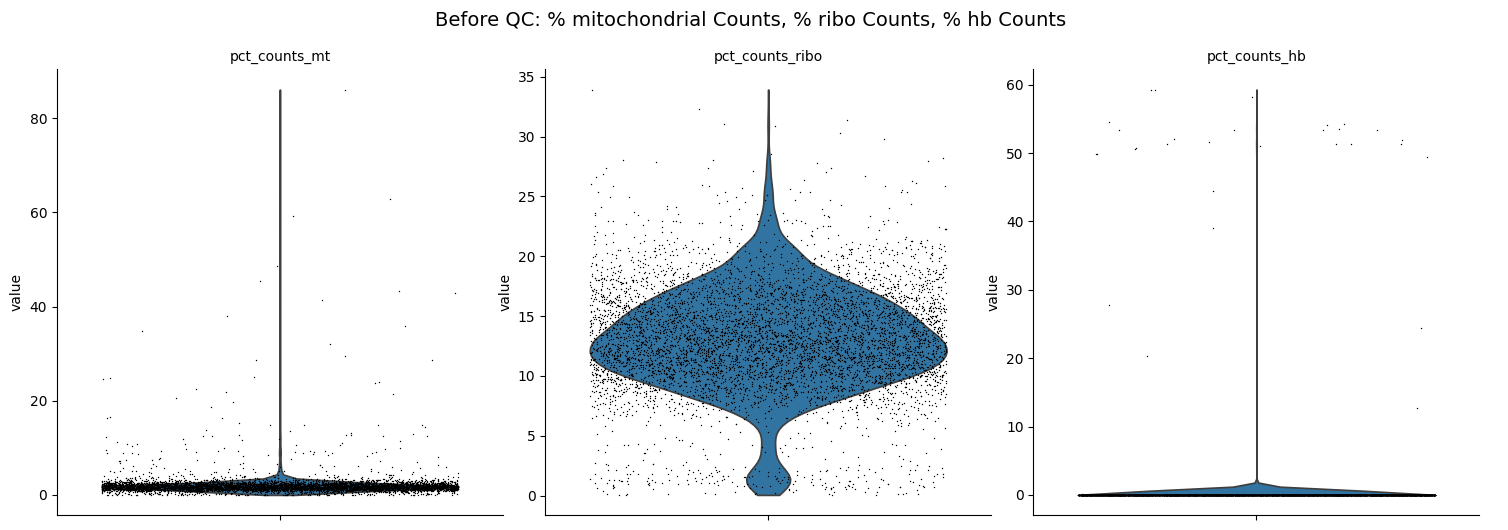

In [10]:
#violin plots for mt, ribo, and hb
sc.pl.violin(
    adata,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
    show = False
)
# Add a summary title
plt.suptitle("Before QC: % mitochondrial Counts, % ribo Counts, % hb Counts", fontsize=14, y=1.05)

# Display the updated figure
plt.show()


#filtering
sc.pp.filter_cells(adata, min_genes=200) #filter out cells (dying cells...?)
sc.pp.filter_genes(adata, min_cells=5) #filterout genes

adata #check how many cell and genes left

#### the percentage of counts in mitochondrial genes, ribo genes, and hb genes

# 1st Filtering
### remove cells with genes <200 
### remove genes found in <5 cells

In [11]:
#check adata before filtering
adata 

AnnData object with n_obs × n_vars = 6224 × 32285
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [12]:
#filtering
adata_filtered = sc.pp.filter_cells(adata, min_genes=200) #filter out cells (dying cells...?)
adata_filtered = sc.pp.filter_genes(adata, min_cells=5) #filterout genes

adata_filtered #check how many cell and genes left

# 2nd Filtering
### remove cells of high counts >6500 
### remove mt pct >10%
### remove cells of hb pct>10%

In [26]:
adata_filtered = adata[adata.obs.n_genes_by_counts < 6500, :]
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_mt < 10, :].copy()
adata_filtered = adata_filtered[adata_filtered.obs.pct_counts_hb < 10,:].copy()

# Check the number of cells and genes after filtering
adata_filtered
#print(f"Number of cells left: {adata_filtered.n_obs}")
#print(f"Number of genes left: {adata_filtered.n_vars}")

AnnData object with n_obs × n_vars = 6122 × 16566
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

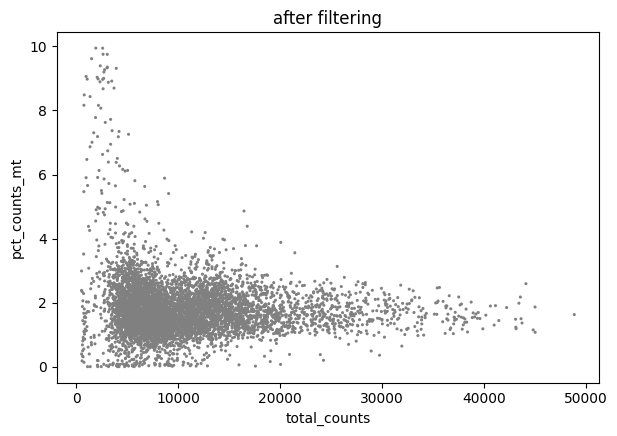

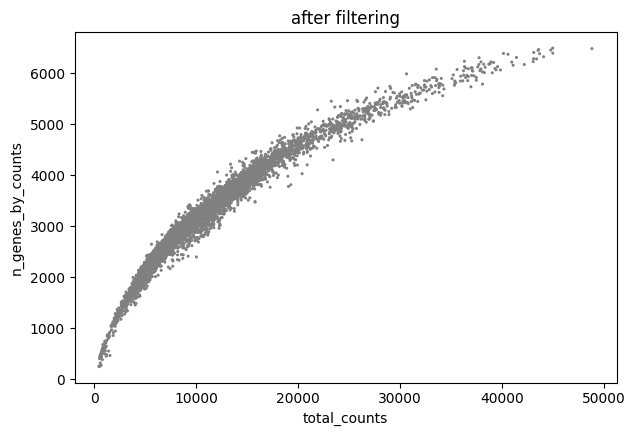

In [27]:
sc.pl.scatter(adata_filtered, x="total_counts", y="pct_counts_mt", title="after filtering")
sc.pl.scatter(adata_filtered, x="total_counts", y="n_genes_by_counts", title="after filtering")

# Detect Doublets

In [28]:
adata_filtered.obs["sample_id"]=sample_id
sc.pp.scrublet(adata_filtered, batch_key= "sample_id")


In [29]:
print((adata_filtered.obs["predicted_doublet"] == True).sum())
#there is one doublets

1


In [30]:
#get the info of the one doublet
adata_doublets = adata_filtered[adata_filtered.obs["predicted_doublet"] == True, :]
print(adata_doublets.obs)

                    n_genes_by_counts  total_counts  \
ACTTATCGTTCGGGTC-1               4062       12114.0   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
ACTTATCGTTCGGGTC-1                   17.789335                    24.550107   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
ACTTATCGTTCGGGTC-1                    33.696549                    49.678058   

                    total_counts_mt  pct_counts_mt  total_counts_ribo  \
ACTTATCGTTCGGGTC-1            174.0       1.436355             1157.0   

                    pct_counts_ribo  total_counts_hb  pct_counts_hb  n_genes  \
ACTTATCGTTCGGGTC-1         9.550933              0.0            0.0     4062   

                          sample_id  doublet_score  predicted_doublet  
ACTTATCGTTCGGGTC-1  blood_12w_KO_02       0.606218               True  


In [31]:
#remove the doublet
# Filter out doublets
adata_filtered = adata_filtered[adata_filtered.obs["predicted_doublet"] == False, :].copy()

# Verify the shape of the filtered AnnData object
print(adata_filtered) #-1 in obs

AnnData object with n_obs × n_vars = 6121 × 16566
    obs: 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'n_genes', 'sample_id', 'doublet_score', 'predicted_doublet'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'scrublet'


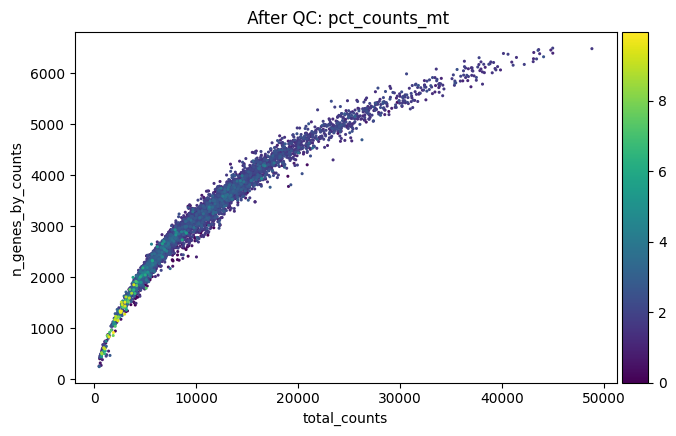

In [32]:
#get the scatter plot of pct_counts_mt
sc.pl.scatter(adata_filtered, "total_counts", "n_genes_by_counts", color="pct_counts_mt", title=" After QC: pct_counts_mt")

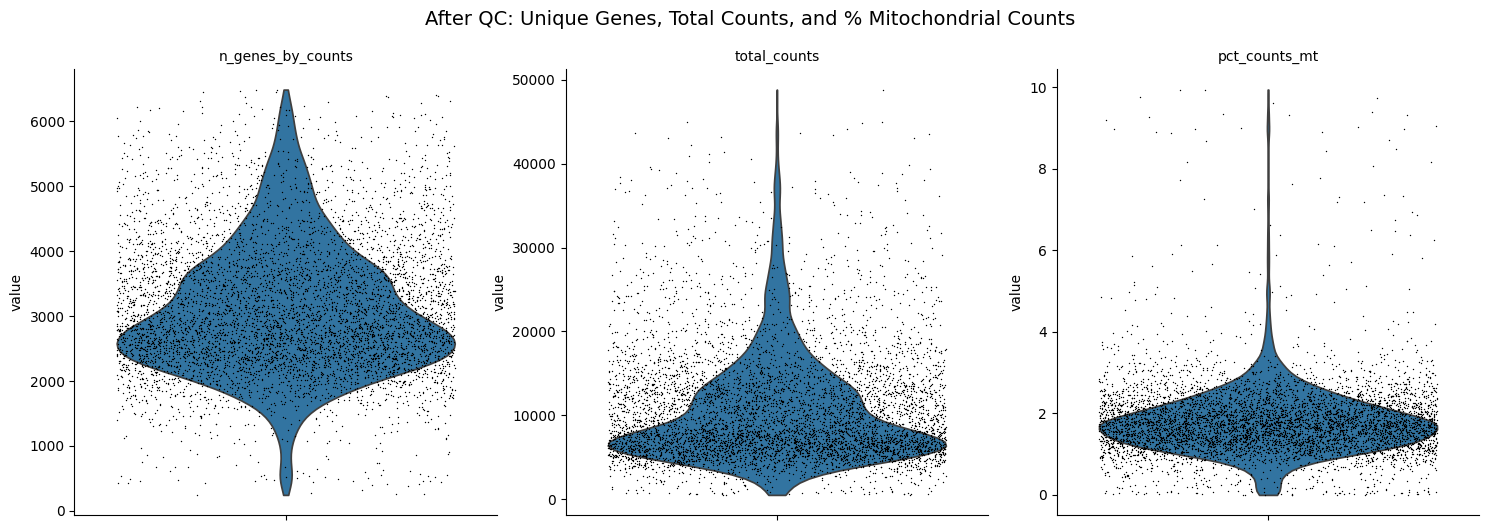

In [33]:
#an extra step to look at the violin plots of adata_filtered
sc.pl.violin(
    adata_filtered,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    show=False
)

#add a title
plt.suptitle("After QC: Unique Genes, Total Counts, and % Mitochondrial Counts", fontsize=14, y=1.05)
plt.show()

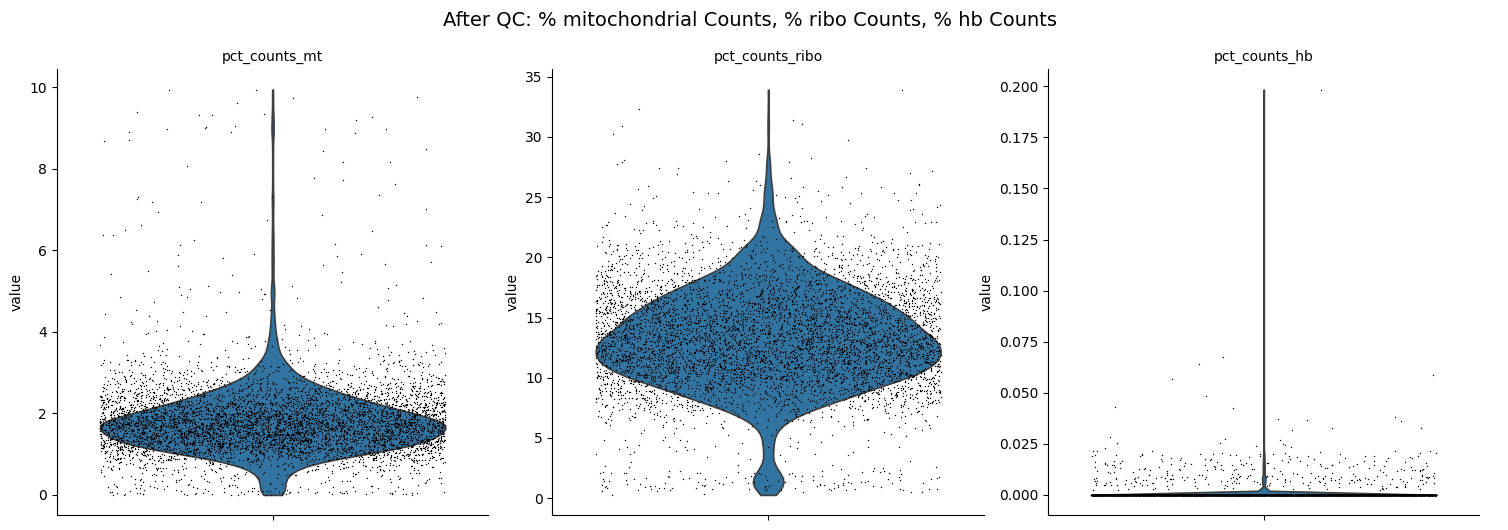

In [34]:
#violin plots for mt, ribo, and hb
sc.pl.violin(
    adata_filtered,
    ["pct_counts_mt", "pct_counts_ribo", "pct_counts_hb"],
    jitter=0.4,
    multi_panel=True,
    show = False
)
# Add a summary title
plt.suptitle("After QC: % mitochondrial Counts, % ribo Counts, % hb Counts", fontsize=14, y=1.05)

# Display the updated figure
plt.show()


# Normalisation


In [35]:
sc.pp.normalize_total(adata_filtered, target_sum=1e4) #normalise to 10,000 reads per cell

In [36]:
#log transform
sc.pp.log1p(adata_filtered)

# Identify highly variable genes

In [37]:

sc.pp.highly_variable_genes(adata_filtered, min_mean =0.0125, max_mean=5, min_disp =0.5) #min_disp is the cut off

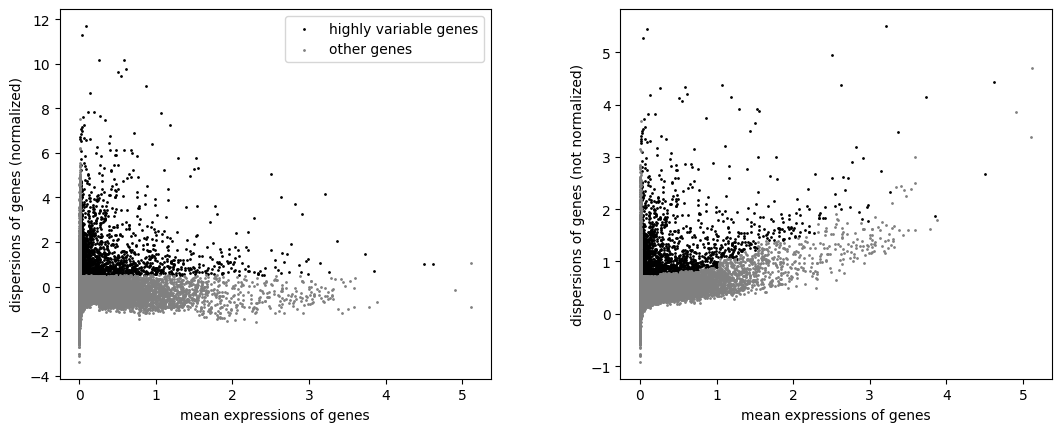

In [38]:
sc.pl.highly_variable_genes(adata_filtered)

In [39]:
#check how many highly variable genes we extract:
num_hvg = adata_filtered.var["highly_variable"].sum()
print(f"Number of highly variable genes: {num_hvg}")

Number of highly variable genes: 2113
